### Bibliotecas

In [ ]:
from google.colab import drive
import os
import subprocess
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

### Carregamento dos dados (Google Drive)

In [ ]:
dataset_path = '/content/drive/MyDrive/N-BaIoT_light.zip'
local_dataset_path = '/content/N-BaIoT'

print(f"Extraindo {dataset_path} para {local_dataset_path}")
subprocess.run(['unzip', '-o', dataset_path, '-d', local_dataset_path])

Extraindo /content/drive/MyDrive/N-BaIoT_light.zip para /content/N-BaIoT


CompletedProcess(args=['unzip', '-o', '/content/drive/MyDrive/N-BaIoT_light.zip', '-d', '/content/N-BaIoT'], returncode=0)

### Caminho dos arquivos

In [ ]:
devices = ['SimpleHome_XCS7_1003_WHT_Security_Camera',
           'Philips_B120N10_Baby_Monitor',
           #'Provision_PT_838_Security_Camera',
           'Danmini_Doorbell',
           'Ecobee_Thermostat'
           ]

benign_csv_path_list = []
mirai_csv_path_list = []

for device in devices:
    benign_file_path = f'N-BaIoT/{device}/benign_traffic.csv'
    benign_csv_path_list.append(benign_file_path)

    mirai_data_folder = f'N-BaIoT/{device}/mirai_attacks'
    for csv_file in os.listdir(mirai_data_folder):
      csv_path = os.path.join(mirai_data_folder, csv_file)
      mirai_csv_path_list.append(csv_path)

print(benign_csv_path_list)
print(mirai_csv_path_list)

['N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/benign_traffic.csv', 'N-BaIoT/Danmini_Doorbell/benign_traffic.csv', 'N-BaIoT/Ecobee_Thermostat/benign_traffic.csv']
['N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udpplain.csv', 'N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/syn.csv', 'N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udp.csv', 'N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/scan.csv', 'N-BaIoT/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/ack.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/mirai_attacks/udpplain.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/mirai_attacks/syn.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/mirai_attacks/udp.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/mirai_attacks/scan.csv', 'N-BaIoT/Philips_B120N10_Baby_Monitor/mirai_attacks/ack.csv', 'N-BaIoT/Danmini_Doorbell/mirai_attacks/udpplain.csv', 'N-BaIoT/Danmini_Doorbell/

### Leitura dos dados

In [ ]:
data_df = pd.DataFrame()

print("Carregando dados de tráfego benigno...")
for file_path in benign_csv_path_list:
    file_df = pd.read_csv(file_path, low_memory=False)

    file_df['label'] = 'benign_traffic'
    data_df = pd.concat([data_df, file_df], ignore_index=True)

print("Carregando dados de ataques mirai...")
for file_path in mirai_csv_path_list:
    attack_name = os.path.basename(file_path).replace('.csv', '')
    prefix = 'mirai_'
    file_df = pd.read_csv(file_path, low_memory=False)

    file_df['label'] = prefix + attack_name
    data_df = pd.concat([data_df, file_df], ignore_index=True)

print(data_df.shape)

Carregando dados de tráfego benigno...
Carregando dados de ataques mirai...
(2547236, 116)


In [ ]:
print(data_df)

         MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
0                1.000000       60.000000            0.000000   
1                1.000000       60.000000            0.000000   
2                1.000000       60.000000            0.000000   
3                1.000000      590.000000            0.000000   
4                1.927179      590.000000            0.000000   
...                   ...             ...                 ...   
2547231        173.619105      437.422636        48522.702098   
2547232        174.618532      438.158969        48338.957342   
2547233        175.617377      438.886921        48156.238007   
2547234        176.614910      439.606640        47974.543331   
2547235        176.577445      440.322436        47792.811549   

         MI_dir_L3_weight  MI_dir_L3_mean  MI_dir_L3_variance  \
0                1.000000       60.000000            0.000000   
1                1.000000       60.000000            0.000000   
2                1.00000

In [ ]:
data_df.isnull().sum().unique()

array([0])

In [ ]:
data_df.dtypes.unique()
data_df.select_dtypes(include='object').columns.tolist()

['label']

In [ ]:
data_df.info()
data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547236 entries, 0 to 2547235
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), object(1)
memory usage: 2.2+ GB


,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
count,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,...,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06,2.547236e+06
mean,1.138515e+02,2.656995e+02,2.626853e+04,1.808406e+02,2.659909e+02,2.917636e+04,5.215779e+02,2.665101e+02,3.141774e+04,5.053801e+03,...,7.847938e+02,4.331842e+00,-1.883135e-04,1.513363e+03,2.664442e+02,1.857868e+00,2.723085e+02,1.161748e+03,6.032627e+00,3.457358e-03
std,5.335243e+01,1.800598e+02,2.692772e+04,8.266521e+01,1.717277e+02,2.734004e+04,2.318604e+02,1.649770e+02,2.751772e+04,2.213431e+03,...,1.508354e+04,1.468540e+03,4.530179e-02,5.456720e+03,2.413971e+02,1.699605e+01,2.400664e+02,1.662692e+04,1.733785e+03,5.339921e-02
min,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,...,0.000000e+00,-1.312975e+05,-1.586467e+00,1.000000e+00,6.000000e+01,0.000000e+00,6.000000e+01,0.000000e+00,-1.820963e+05,-1.732641e+00
25%,9.391604e+01,6.938921e+01,1.808577e+01,1.506002e+02,6.965041e+01,2.765561e+01,4.691219e+02,6.996211e+01,3.709114e+01,4.769347e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.208671e+02,2.820617e+02,2.064192e+04,1.998786e+02,3.172159e+02,3.352365e+04,6.163355e+02,3.562052e+02,4.477664e+04,6.263864e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.400000e+01,0.000000e+00,8.485281e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.497492e+02,4.339469e+02,5.451104e+04,2.346778e+02,4.194862e+02,5.585079e+04,6.639651e+02,4.081976e+02,5.499406e+04,6.433505e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.540000e+02,0.000000e+00,5.540000e+02,0.000000e+00,0.000000e+00,0.000000e+00
max,4.380028e+02,1.452697e+03,4.756482e+05,5.058053e+02,1.450730e+03,4.714568e+05,1.210948e+03,1.434056e+03,4.713175e+05,8.946997e+03,...,5.014297e+05,1.309683e+05,1.949807e+00,3.000666e+04,1.437326e+03,6.810012e+02,1.438842e+03,4.790662e+05,1.438641e+05,1.953555e+00


### Mapeamento de classes

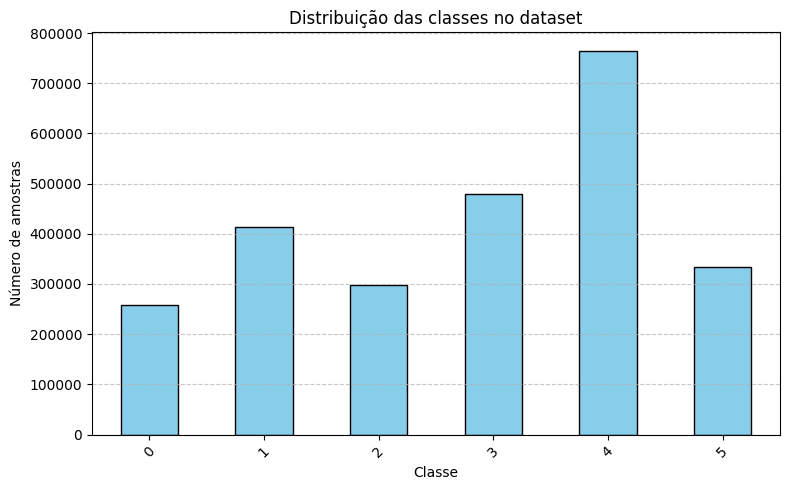


📊 Distribuição das classes (percentual):
label
0    10.106209
1    16.244667
2    11.705708
3    18.843444
4    29.964401
5    13.135571
Name: proportion, dtype: float64

📊 Distribuição das classes (absoluta):
label
4    763264
3    479987
1    413790
5    334594
2    298172
0    257429
Name: count, dtype: int64
         MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
0                1.000000       60.000000            0.000000   
1                1.000000       60.000000            0.000000   
2                1.000000       60.000000            0.000000   
3                1.000000      590.000000            0.000000   
4                1.927179      590.000000            0.000000   
...                   ...             ...                 ...   
2547231        173.619105      437.422636        48522.702098   
2547232        174.618532      438.158969        48338.957342   
2547233        175.617377      438.886921        48156.238007   
2547234        176.614910      439.

In [ ]:
# Mapa de classes
label_mapping = {
    'benign_traffic': 0,
    'mirai_ack': 1,
    'mirai_scan': 2,
    'mirai_syn': 3,
    'mirai_udp': 4,
    'mirai_udpplain': 5
}

# Mapeamento de classes
data_df['label'] = data_df['label'].map(label_mapping)

# Contagem por nome da classe
class_counts = data_df['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição das classes no dataset')
plt.xlabel('Classe')
plt.ylabel('Número de amostras')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n📊 Distribuição das classes (percentual):")
print(data_df['label'].value_counts(normalize=True).sort_index() * 100)

print("\n📊 Distribuição das classes (absoluta):")
print(data_df['label'].value_counts())

print(data_df)

### Divisão de treinamento, validação e teste

In [ ]:
# Separar X e y
X = data_df.drop(columns=['label'])  # todas as colunas menos 'label'
y = data_df['label']                 # coluna alvo

# 1º Split: Treino + Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2º Split: Validação e Teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Converter para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# Resultado
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)
print(data_df)
print(X_train)

Train: (1783065, 115)
Val: (382085, 115)
Test: (382086, 115)
         MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
0                1.000000       60.000000            0.000000   
1                1.000000       60.000000            0.000000   
2                1.000000       60.000000            0.000000   
3                1.000000      590.000000            0.000000   
4                1.927179      590.000000            0.000000   
...                   ...             ...                 ...   
2547231        173.619105      437.422636        48522.702098   
2547232        174.618532      438.158969        48338.957342   
2547233        175.617377      438.886921        48156.238007   
2547234        176.614910      439.606640        47974.543331   
2547235        176.577445      440.322436        47792.811549   

         MI_dir_L3_weight  MI_dir_L3_mean  MI_dir_L3_variance  \
0                1.000000       60.000000            0.000000   
1                1.000000   

### Treinamento

In [ ]:
# Parâmetros
params = {
    'objective': 'multi:softprob',
    'num_class': len(label_mapping),
    'eval_metric': 'mlogloss',
    'verbosity': 1
}

evals_result = {}
evals = [(dtrain, 'train'), (dval, 'val')]
num_boost_round=100

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-mlogloss:0.99270	val-mlogloss:0.99271
[1]	train-mlogloss:0.67024	val-mlogloss:0.67025
[2]	train-mlogloss:0.47201	val-mlogloss:0.47202
[3]	train-mlogloss:0.33899	val-mlogloss:0.33901
[4]	train-mlogloss:0.24616	val-mlogloss:0.24618
[5]	train-mlogloss:0.17991	val-mlogloss:0.17993
[6]	train-mlogloss:0.13211	val-mlogloss:0.13212
[7]	train-mlogloss:0.09728	val-mlogloss:0.09728
[8]	train-mlogloss:0.07178	val-mlogloss:0.07178
[9]	train-mlogloss:0.05307	val-mlogloss:0.05307
[10]	train-mlogloss:0.03929	val-mlogloss:0.03929
[11]	train-mlogloss:0.02912	val-mlogloss:0.02912
[12]	train-mlogloss:0.02158	val-mlogloss:0.02158
[13]	train-mlogloss:0.01600	val-mlogloss:0.01600
[14]	train-mlogloss:0.01186	val-mlogloss:0.01186
[15]	train-mlogloss:0.00879	val-mlogloss:0.00879
[16]	train-mlogloss:0.00652	val-mlogloss:0.00652
[17]	train-mlogloss:0.00484	val-mlogloss:0.00484
[18]	train-mlogloss:0.00359	val-mlogloss:0.00359
[19]	train-mlogloss:0.00266	val-mlogloss:0.00267
[20]	train-mlogloss:0.00198	va

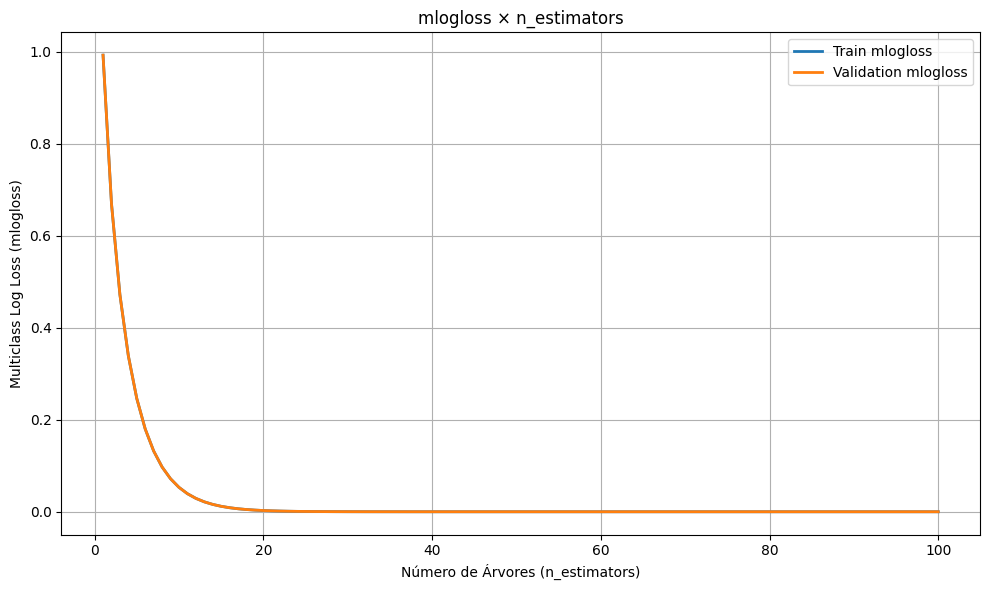

In [ ]:
# Plotar mlogloss vs n_estimators
train_mlogloss = evals_result['train']['mlogloss']
eval_mlogloss = evals_result['val']['mlogloss']
rounds = list(range(1, num_boost_round + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_mlogloss, label='Train mlogloss', linewidth=2)
plt.plot(rounds, eval_mlogloss, label='Validation mlogloss', linewidth=2)
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('Multiclass Log Loss (mlogloss)')
plt.title('mlogloss × n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Teste

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38614
         1.0       1.00      1.00      1.00     62069
         2.0       1.00      1.00      1.00     44726
         3.0       1.00      1.00      1.00     71998
         4.0       1.00      1.00      1.00    114490
         5.0       1.00      1.00      1.00     50189

    accuracy                           1.00    382086
   macro avg       1.00      1.00      1.00    382086
weighted avg       1.00      1.00      1.00    382086

✅ Accuracy: 0.9999973827881681


<Figure size 800x600 with 0 Axes>

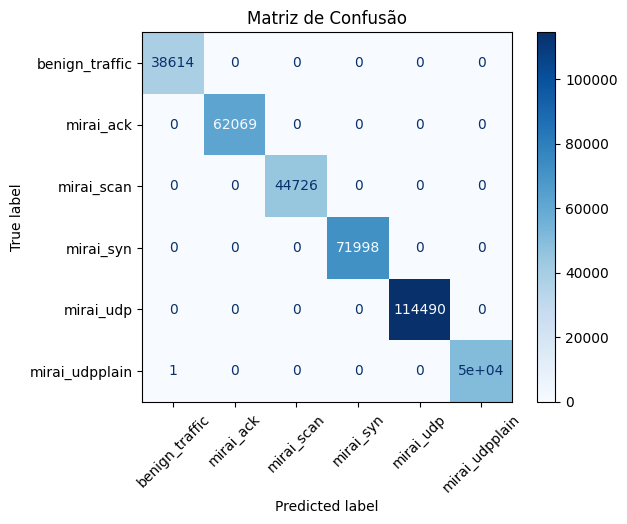

In [ ]:
# Previsões em forma de probabilidade
y_pred_prob = model.predict(dtest)

# Converter para rótulos (classe com maior probabilidade)
y_pred = np.argmax(y_pred_prob, axis=1)

# Valores reais
y_true = dtest.get_label()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred))

print("✅ Accuracy:", accuracy_score(y_true, y_pred))

# Gerar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))

# Plotar a imagem
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Matriz de Confusão')
plt.show()